In [1]:
import torch
import deepxde as dde

%cd ..
from models import FNO2d
from train_utils.datasets import MatReader, AdvectionLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


/home/tp526/neuraloperator/PI-FNO-reproduce


<h2>Load model</h2>

In [22]:
config = {"model": {  
              "layers": [32, 32, 32, 32], #[16, 24, 24, 32, 32],
              "modes1": [15, 12, 9, 9],
              "modes2": [15, 12, 9, 9],
              "fc_dim": 64,
              "act": "gelu",
              "num_pad": 4,
            },
          }

In [24]:
model = FNO2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              act=config['model']['act']).to(device)

ckpt_path = "checkpoints/advection-FDM/advection-data-0-pde-1-4-32-mode-15.pt"
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

<h2>Generate Ground Truths</h2>

Generating 100 samples of time-dependent traffic equation ...
Processing sample 50/100...
Processing sample 100/100...

Generation complete.
x shape: (100, 100)
y shape: (100, 101, 100)


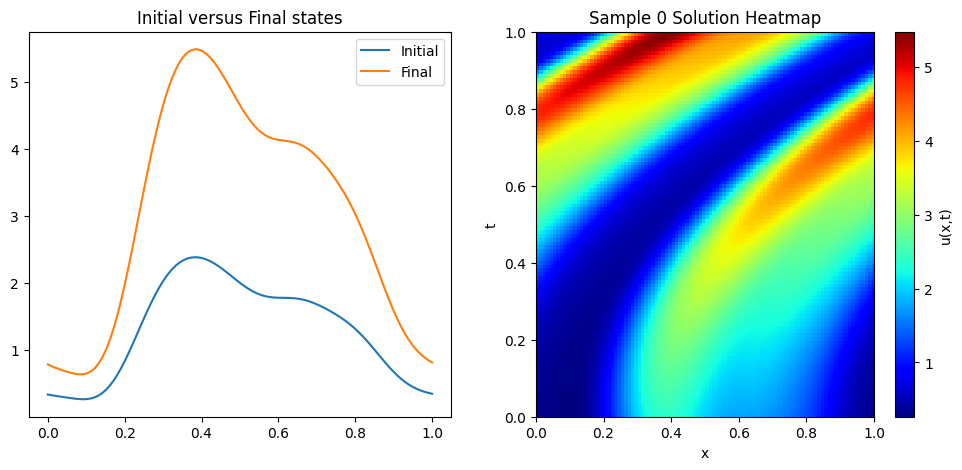

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def solve_advection_reaction(u0, x_max=1.0, t_max=1.0, Nx=100, Nt=101, plot=False):
    """
    Solves u_t + 2*t*u_x = cos(t)*u on x in [0, 1), t in [0, t_max].
    Uses a Semi-Lagrangian scheme (unconditionally stable).
    
    Args:
        Nx (int): Spatial resolution.
        Nt (int): Temporal resolution (number of time steps).
        t_max (float): Final time.
        u_init_func (callable): Function taking array x and returning initial u.
        plot_results (bool): If True, generates the requested plots.
        
    Returns:
        tuple: (x_grid, t_grid, u_solution)
            x_grid: 1D array of size Nx
            t_grid: 1D array of size Nt
            u_solution: 2D array of shape (Nt, Nx)
    """
    
    # 1. Setup Grids
    # Endpoint=False for periodic boundary to avoid duplicating the point at x=1
    x = np.linspace(0, x_max, Nx, endpoint=False) 
    t = np.linspace(0, t_max, Nt, endpoint=True)
    dt = t[1] - t[0]
    
    # Initialize solution matrix
    u = np.zeros((Nt, Nx))
    
    # 2. Set Initial Condition
    u[0, :] = u0
    
    # 3. Time Stepping Loop
    for n in range(Nt - 1):
        t_current = t[n]
        t_next = t[n+1]
        
        # --- Step A: Advection (Semi-Lagrangian) ---
        # Characteristic displacement: integral of velocity (2t) from t_current to t_next
        # x(t) = t^2 + C  => displacement = t_next^2 - t_current^2
        displacement = t_next**2 - t_current**2
        
        # Find the 'source' locations x_star such that particles move to grid points x
        # x = x_star + displacement => x_star = x - displacement
        x_star = x - displacement
        
        # Enforce periodicity on the source coordinates
        x_star_periodic = np.mod(x_star, 1.0)
        
        # Interpolate values from the previous time step at these source locations
        # np.interp works with 1D data. xp must be increasing, so we append the periodic wrap.
        # We append the first point (x=0) to the end (x=1) to allow correct interpolation across boundary
        u_prev_extended = np.append(u[n, :], u[n, 0])
        x_extended = np.append(x, 1.0)
        
        u_advected = np.interp(x_star_periodic, x_extended, u_prev_extended)
        
        # --- Step B: Reaction / Source Term ---
        # Exact integration of du/dt = cos(t)u  => u(t) = u(0) * exp(sin(t) - sin(t0))
        growth_factor = np.exp(np.sin(t_next) - np.sin(t_current))
        
        u[n+1, :] = u_advected * growth_factor

    # 4. Plotting
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot 1: Initial vs Final State
        axes[0].plot(x, u[0, :], 'b--', label=f'Initial (t=0)')
        axes[0].plot(x, u[-1, :], 'r-', linewidth=2, label=f'Final (t={t_max})')
        axes[0].set_title("Initial and Final States")
        axes[0].set_xlabel("x")
        axes[0].set_ylabel("u(x,t)")
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
        
        # Plot 2: Space-Time Heatmap
        # Using extent to map array indices to physical units [0, 1] and [0, t_max]
        im = axes[1].imshow(u, aspect='auto', origin='lower', 
                            extent=[0, 1, 0, t_max], cmap='jet')
        axes[1].set_title("Space-Time Evolution u(x,t)")
        axes[1].set_xlabel("Space (x)")
        axes[1].set_ylabel("Time (t)")
        fig.colorbar(im, ax=axes[1], label='Magnitude')
        
        plt.tight_layout()
        plt.show()
        
    return u


def create_advection_dataset(N_SAMPLES=200, Nx=100, Nt=101, X_MUL=4, T_MUL=5, LENGTH_SCALE=1.0, ics=None):
    """
    Generates dataset and returns dictionary with NumPy arrays.
    """
    print(f"Generating {N_SAMPLES} samples of time-dependent traffic equation ...")
    
    # Pre-allocate arrays
    x_data = np.zeros((N_SAMPLES, Nx))      # To store Initial Conditions
    y_data = np.zeros((N_SAMPLES, Nt, Nx))  # To store Solutions

    func_space = dde.data.GRF(kernel="ExpSineSquared", length_scale=LENGTH_SCALE)
    feats = func_space.random(N_SAMPLES)

    xs = np.linspace(0, 1, Nx*X_MUL, endpoint=False)
    if ics is not None:
        ics_all = np.zeros((N_SAMPLES, Nx*X_MUL))
        # interpolate ics to match the resolution
        x_res = ics.shape[1]
        x_grid = np.linspace(0, 1, x_res+1, endpoint=True)
        for k in range(N_SAMPLES):
            ic_pad = np.append(ics[k], ics[k][0])
            ic = interp1d(x_grid, ic_pad, "linear")
            ics_all[k] = ic(xs)

    else:  
        ics_all = func_space.eval_batch(feats, xs)
    
    for i in range(N_SAMPLES):
        if (i+1) % 50 == 0:
            print(f"Processing sample {i+1}/{N_SAMPLES}...")
            
        # 1. Generate IC
        u0 = ics_all[i]
        
        # 2. Solve
        u_sol = solve_advection_reaction(u0, Nx=Nx*X_MUL, Nt=(Nt-1)*T_MUL+1)
        
        # 3. Store
        x_data[i] = u0[::X_MUL]
        y_data[i] = u_sol[::T_MUL, ::X_MUL]

    # 4. Pack into dictionary (NumPy arrays only)
    advection_128 = {
        'x': x_data,
        'y': y_data
    }
    
    print("\nGeneration complete.")
    print(f"x shape: {advection_128['x'].shape}")
    print(f"y shape: {advection_128['y'].shape}")
    
    return advection_128

# --- Example Usage ---
if __name__ == "__main__":
    # Generate data
    data_dict = create_advection_dataset(N_SAMPLES=100, Nx=100, Nt=101, X_MUL=4, T_MUL=4)
    
    # Verification Plot
    sample_idx = np.random.randint(1)
    x_grid = np.linspace(0, 1, 100)
    u_field = data_dict['y'][sample_idx]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)    
    plt.plot(x_grid, u_field[0], label="Initial")
    plt.plot(x_grid, u_field[-1], label="Final")
    plt.title("Initial versus Final states")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.imshow(u_field, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
    plt.colorbar(label="u(x,t)")
    plt.title(f"Sample {sample_idx} Solution Heatmap")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()

In [17]:
# Generate data
data_dict = create_advection_dataset(N_SAMPLES=800, Nx=100, Nt=101, X_MUL=4, T_MUL=4)

import scipy

# We map 'x' -> 'input' and 'y' -> 'output'
mat_data = {
    'input': data_dict['x'],
    'output': data_dict['y']
}

# 3. Save to .mat file
# do_compression=True helps if the arrays are large
scipy.io.savemat('/home/tp526/neuraloperator/data/advection_pino.mat', mat_data, do_compression=True)

print("Saved to /home/tp526/neuraloperator/data/advection_pino.mat")

Generating 800 samples of time-dependent traffic equation ...
Processing sample 50/800...
Processing sample 100/800...
Processing sample 150/800...
Processing sample 200/800...
Processing sample 250/800...
Processing sample 300/800...
Processing sample 350/800...
Processing sample 400/800...
Processing sample 450/800...
Processing sample 500/800...
Processing sample 550/800...
Processing sample 600/800...
Processing sample 650/800...
Processing sample 700/800...
Processing sample 750/800...
Processing sample 800/800...

Generation complete.
x shape: (800, 100)
y shape: (800, 101, 100)
Saved to /home/tp526/neuraloperator/data/advection_pino.mat


<h2>Test the model</h2>

In [5]:
def format_advection_data(data_dict):
    """
    Reshapes the Burgers dataset into a coordinate-based format.
    
    Args:
        data_dict (dict): Dictionary with keys 'x' (N, Nx) and 'y' (N, Nt, Nx).
        
    Returns:
        np.array: A single array of shape (N_SAMPLES, Nt, Nx, 3).
                  Channel 0: u0(x) repeated over time
                  Channel 1: x coordinates
                  Channel 2: t coordinates
    """
    # 1. Extract dimensions
    # data_dict['x'] is the initial condition u0, shape (N, Nx)
    # data_dict['y'] is the solution u, shape (N, Nt, Nx)
    u0 = data_dict['x'] 
    N_samples, Nx = u0.shape
    Nt = data_dict['y'].shape[1]
    
    print(f"Dimensions detected: N={N_samples}, Nt={Nt}, Nx={Nx}")

    # 2. Create Mesh Grids (Nt, Nx)
    # Recreate the grids used in the solver
    x_1d = np.linspace(0, 1, Nx, endpoint=False)
    t_1d = np.linspace(0, 1, Nt)
    
    # Create 2D grids. indexing='ij' ensures output is (Nt, Nx)
    # T_grid varies along axis 0, X_grid varies along axis 1
    T_grid, X_grid = np.meshgrid(t_1d, x_1d, indexing='ij')
    
    # 3. Broadcast/Repeat Arrays to shape (N, Nt, Nx)
    
    # Channel 0: u0 (Initial Condition)
    # Input: (N, Nx) -> Expand to (N, 1, Nx) -> Tile to (N, Nt, Nx)
    u0_expanded = np.tile(u0[:, None, :], (1, Nt, 1))
    
    # Channel 1: X Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    X_expanded = np.tile(X_grid[None, :, :], (N_samples, 1, 1))
    
    # Channel 2: T Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    T_expanded = np.tile(T_grid[None, :, :], (N_samples, 1, 1))
    
    # 4. Stack along the last axis
    # Result shape: (N, Nt, Nx, 3, 1)
    formatted_data = np.stack([u0_expanded, X_expanded, T_expanded], axis=-1)
    
    return formatted_data

In [6]:
# Create test data
data_dict = create_advection_dataset(N_SAMPLES=1000, Nx=100, Nt=101, X_MUL=4, T_MUL=4)

formatted_inputs = format_advection_data(data_dict)
formatted_inputs.shape

Generating 1000 samples of time-dependent traffic equation ...
Processing sample 50/1000...
Processing sample 100/1000...
Processing sample 150/1000...
Processing sample 200/1000...
Processing sample 250/1000...
Processing sample 300/1000...
Processing sample 350/1000...
Processing sample 400/1000...
Processing sample 450/1000...
Processing sample 500/1000...
Processing sample 550/1000...
Processing sample 600/1000...
Processing sample 650/1000...
Processing sample 700/1000...
Processing sample 750/1000...
Processing sample 800/1000...
Processing sample 850/1000...
Processing sample 900/1000...
Processing sample 950/1000...
Processing sample 1000/1000...

Generation complete.
x shape: (1000, 100)
y shape: (1000, 101, 100)
Dimensions detected: N=1000, Nt=101, Nx=100


(1000, 101, 100, 3)

In [27]:
import scipy

# We map 'x' -> 'input' and 'y' -> 'output'
mat_data = {
    'input': data_dict['x'],
    'output': data_dict['y']
}

# 3. Save to .mat file
# do_compression=True helps if the arrays are large
scipy.io.savemat('/home/tp526/neuraloperator/data/test_data/advection_truth_x100_t101_1000.mat', mat_data, do_compression=True)

print("Saved to /home/tp526/neuraloperator/data/test_data/advection_truth_x100_t101_1000.mat")

Saved to /home/tp526/neuraloperator/data/test_data/advection_truth_x100_t101_1000.mat


Input shape:  torch.Size([1, 101, 100, 3])
Output shape:  torch.Size([1, 101, 100])


==Relative L2 error mean:  0.043267==

Ground Truth


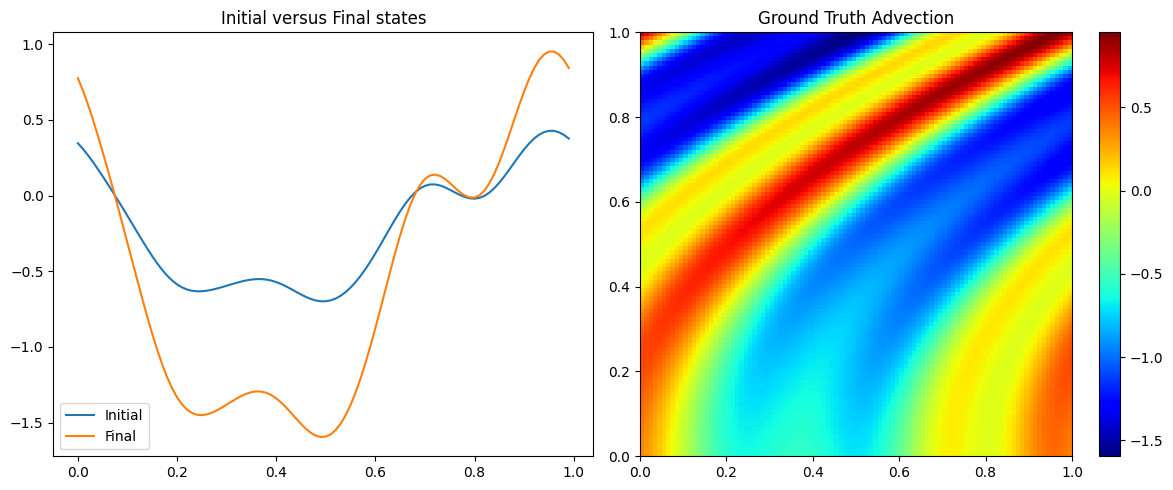

Prediction


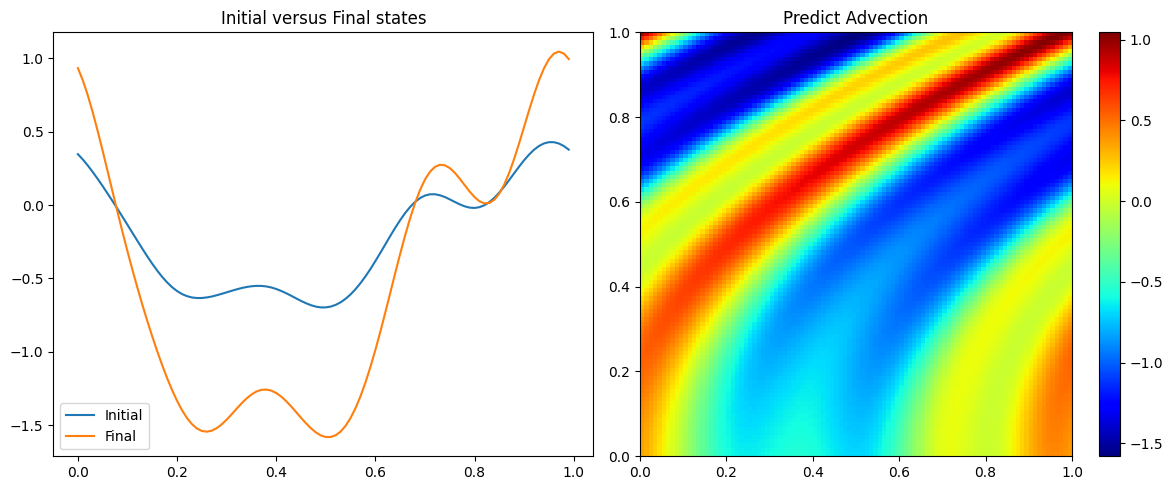

In [25]:
k = np.random.randint(1000)

x, y = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device), torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

print("Input shape: ", x.shape)
print("Output shape: ", y.shape)
print("\n")

out = model(x).reshape(y.shape)

data_loss = torch.norm(out - y) / torch.norm(y)

print(f'==Relative L2 error mean: {data_loss.item() : .6f}==\n')

# Plot
print("Ground Truth")
truth = y[0].detach().cpu().numpy()
x_grid = np.linspace(0, 1, truth.shape[1], endpoint=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, truth[0], label="Initial")
plt.plot(x_grid, truth[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(truth, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Advection")
plt.colorbar()

plt.tight_layout()
plt.show()

print("Prediction")
pred = out[0].detach().cpu().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, pred[0], label="Initial")
plt.plot(x_grid, pred[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(pred, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Predict Advection")
plt.colorbar()

plt.tight_layout()
plt.show()



In [31]:
dataset = BurgersLoader("/home/tp526/neuraloperator/data/burgers_pino.mat",
                            nx=128, nt=100,
                            sub=1, sub_t=1, new=True)
train_loader = dataset.make_loader(n_sample=10,
                                    batch_size=1,
                                    start=0)

/home/tp526/.conda/envs/dde/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [9]:
import scipy

# We map 'x' -> 'input' and 'y' -> 'output'
mat_data = {
    'input': data_dict['x'],
    'output': data_dict['y'],
    'visc': data_dict['visc']
}

# 3. Save to .mat file
# do_compression=True helps if the arrays are large
scipy.io.savemat('/home/tp526/neuraloperator/data/traffic_pino.mat', mat_data, do_compression=True)

print("Saved to /home/tp526/neuraloperator/data/traffic_pino.mat")

Saved to /home/tp526/neuraloperator/data/traffic_pino.mat


In [16]:
print("-" * 100)
print("\nNumber of trainable parameters: ", sum(p.numel() for p in model.parameters()))
print("\n" + "-" * 100)

----------------------------------------------------------------------------------------------------

Number of trainable parameters:  933281

----------------------------------------------------------------------------------------------------


<h2>Test</h2>

In [26]:
#model.eval()

N_CASE = formatted_inputs.shape[0]

l2_errors = np.zeros(N_CASE)
l1_errors = np.zeros(N_CASE)

with torch.no_grad():
    for k in range(N_CASE):
        x = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device)
        y = torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

        out = model(x).reshape(y.shape)

        # Relative L2
        l2 = torch.norm(out - y, p=2) / torch.norm(y, p=2)
        l2_errors[k] = l2.item()

        # Relative L1
        l1 = torch.norm(out - y, p=1) / torch.norm(y, p=1)
        l1_errors[k] = l1.item()

        if (k+1) % 20 == 0:
            print(f'Sample {k+1}/{N_CASE}: ')
            print(f'    Mean L2-relative-error: {np.mean(l2_errors[:(k+1)]):.6e}')
            print(f'    Mean L1-relative-error: {np.mean(l1_errors[:(k+1)]):.6e}')
            print("-" * 50 + "\n")

print(f"Mean L2-relative-error over 1000 tests: {np.mean(l2_errors):.6e}")
print(f"Mean L1-relative-error over 1000 tests: {np.mean(l1_errors):.6e}")
print(f"L2 std: {np.std(l2_errors):.6e}")
print(f"L1 std: {np.std(l1_errors):.6e}")


Sample 20/1000: 
    Mean L2-relative-error: 3.101646e-02
    Mean L1-relative-error: 2.261911e-02
--------------------------------------------------

Sample 40/1000: 
    Mean L2-relative-error: 3.191612e-02
    Mean L1-relative-error: 2.270735e-02
--------------------------------------------------

Sample 60/1000: 
    Mean L2-relative-error: 3.291990e-02
    Mean L1-relative-error: 2.329526e-02
--------------------------------------------------

Sample 80/1000: 
    Mean L2-relative-error: 3.277287e-02
    Mean L1-relative-error: 2.328359e-02
--------------------------------------------------

Sample 100/1000: 
    Mean L2-relative-error: 3.321941e-02
    Mean L1-relative-error: 2.358730e-02
--------------------------------------------------

Sample 120/1000: 
    Mean L2-relative-error: 3.389286e-02
    Mean L1-relative-error: 2.402999e-02
--------------------------------------------------

Sample 140/1000: 
    Mean L2-relative-error: 3.455177e-02
    Mean L1-relative-error: 2.441